# 230968078 - Ishan Suryawanshi - Week 8

In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, LSTM, Input, Dense, Embedding, Bidirectional, GRUCell, RNN
import matplotlib.pyplot as plt
tf.config.run_functions_eagerly(True)

2025-10-01 11:13:44.561959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759317224.587790    2462 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759317224.595437    2462 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data = pd.read_csv('/kaggle/input/hin-english/hin.txt', sep='\t', usecols=[0,1], header=None, names=['english','hindi'])

In [3]:
def preprocess_text(text):
    text = str(text).lower().strip()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

data['english'] = data['english'].apply(preprocess_text)
data['hindi'] = data['hindi'].apply(preprocess_text)
data['hindi'] = data['hindi'].apply(lambda x: '<start> ' + str(x) + ' <end>')

In [5]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

In [6]:
eng_tok = Tokenizer(filters='')
eng_tok.fit_on_texts(train_data['english'])
ivs = len(eng_tok.word_index) + 1

hin_tok = Tokenizer(filters='')
hin_tok.fit_on_texts(train_data['hindi'])
tvs = len(hin_tok.word_index) + 1

In [7]:
x_all_seq = eng_tok.texts_to_sequences(data['english'])
y_all_seq = hin_tok.texts_to_sequences(data['hindi'])
mli = max(len(s) for s in x_all_seq)
mlt = max(len(s) for s in y_all_seq)

In [8]:
def tokenize_data(tokenizer, df, column, max_len):
    seq = tokenizer.texts_to_sequences(df[column])
    return pad_sequences(seq, maxlen=max_len, padding='post')

In [9]:
x_train = tokenize_data(eng_tok, train_data, 'english', mli)
y_train = tokenize_data(hin_tok, train_data, 'hindi', mlt)
x_val  = tokenize_data(eng_tok, val_data, 'english', mli)
y_val  = tokenize_data(hin_tok, val_data, 'hindi', mlt)
x_test = tokenize_data(eng_tok, test_data, 'english', mli)
y_test = tokenize_data(hin_tok, test_data, 'hindi', mlt)

In [10]:
def build_lstm_model(ivs, tvs, emb_dim, units, mli, mlt):
    # Encoder
    enc_inputs = Input(shape=(mli,), name='enc_input')
    enc_emb = Embedding(ivs, emb_dim, mask_zero=True, name='enc_embedding')(enc_inputs)
    enc_cell = LSTM(units, return_sequences=False, return_state=True, name='enc_lstm')
    _, state_h, state_c = enc_cell(enc_emb)
    enc_states = [state_h, state_c]

    # Decoder
    dec_inputs = Input(shape=(mlt-1,), name='dec_input')
    dec_emb = Embedding(tvs, emb_dim, mask_zero=True, name='dec_embedding')(dec_inputs)
    dec_cell = LSTM(units, return_sequences=True, return_state=True, name='dec_lstm')
    dec_output, _, _ = dec_cell(dec_emb, initial_state=enc_states)

    # Output Layer
    dec_dense = Dense(tvs, activation='softmax', name='dec_dense')
    dec_outputs = dec_dense(dec_output)

    # Model
    model = Model([enc_inputs, dec_inputs], dec_outputs, name='LSTM_seq2seq')
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
def build_gru_model_rnncell(ivs, tvs, emb_dim, units, mli, mlt):
    enc_inputs = Input(shape=(mli,), name='enc_input_gru')
    enc_emb = Embedding(ivs, emb_dim, mask_zero=True, name='enc_embedding_gru')(enc_inputs)
    enc_gru_cell = GRUCell(units)
    enc_rnn = RNN(enc_gru_cell, return_state=True, name='enc_rnn_gru')
    _, enc_state = enc_rnn(enc_emb)

    dec_inputs = Input(shape=(mlt-1,), name='dec_input_gru')
    dec_emb = Embedding(tvs, emb_dim, mask_zero=True, name='dec_embedding_gru')(dec_inputs)
    dec_gru_cell = GRUCell(units)
    dec_rnn = RNN(dec_gru_cell, return_sequences=True, return_state=True, name='dec_rnn_gru')
    dec_outputs, _ = dec_rnn(dec_emb, initial_state=[enc_state])

    dec_dense = Dense(tvs, activation='softmax', name='dec_dense_gru')
    dec_final = dec_dense(dec_outputs)

    model = Model([enc_inputs, dec_inputs], dec_final, name='GRU_seq2seq_rnncell')
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
y_train_in = y_train[:, :-1]
y_val_in = y_val[:, :-1]
y_test_in = y_test[:, :-1]


In [13]:
y_train_out = np.expand_dims(y_train[:, 1:], -1)
y_val_out = np.expand_dims(y_val[:, 1:], -1)
y_test_out = np.expand_dims(y_test[:, 1:], -1)

In [14]:
def plot_history(histories, name_labels, metric='loss'):
    plt.figure(figsize=(10, 6))
    for history, label in zip(histories, name_labels):
        plt.plot(history.history[metric], label=f'{label} Train')
        plt.plot(history.history['val_' + metric], label=f'{label} Val')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

In [15]:
gru = build_gru_model_rnncell(ivs, tvs, emb_dim=256, units=256, mli=mli, mlt=mlt)
print("\n--- GRU (RNN+GRUCell) Model Summary ---")
gru.summary()

I0000 00:00:1759317228.806294    2462 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759317228.807038    2462 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



--- GRU (RNN+GRUCell) Model Summary ---


Model: "GRU_seq2seq_rnncell"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_input_gru       │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_input_gru       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_embedding_gru   │ (None, 19, 256)   │    549,632 │ enc_input_gru[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 19)        │          0 │ enc_input_gru[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_embedding_gru   │ (None, 3, 256)    │      2,048 │ dec_input_gru[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_rnn_gru (RNN)   │ [(None, 256),     │    394,752 │ enc_embedding_gr… │
│                     │ (None, 256)]      │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_rnn_gru (RNN)   │ [(None, 3, 256),  │    394,752 │ dec_embedding_gr… │
│                     │ (None, 256)]      │            │ enc_rnn_gru[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_dense_gru       │ (None, 3, 8)      │      2,056 │ dec_rnn_gru[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,343,240 (5.12 MB)

 Trainable params: 1,343,240 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
gru_history = gru.fit(
    [x_train, y_train_in], y_train_out,
    validation_data=([x_val, y_val_in], y_val_out),
    batch_size=64, epochs=5, verbose=1
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 365ms/step - accuracy: 0.8882 - loss: 0.9598 - val_accuracy: 1.0000 - val_loss: 7.7458e-05
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 365ms/step - accuracy: 0.9981 - loss: 0.0420 - val_accuracy: 1.0000 - val_loss: 9.3094e-05
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 373ms/step - accuracy: 0.9980 - loss: 0.0366 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 365ms/step - accuracy: 0.9977 - loss: 0.0264 - val_accuracy: 1.0000 - val_loss: 7.7772e-04
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 366ms/step - accuracy: 0.9988 - loss: 0.0112 - val_accuracy: 1.0000 - val_loss: 0.0022


In [17]:
lstm = build_lstm_model(ivs, tvs, emb_dim=256, units=256, mli=mli, mlt=mlt)
print("\n--- LSTM Model Summary ---")
lstm.summary()


--- LSTM Model Summary ---


Model: "LSTM_seq2seq"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_input           │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_input           │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_embedding       │ (None, 19, 256)   │    549,632 │ enc_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 19)        │          0 │ enc_input[0][0]   │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_embedding       │ (None, 3, 256)    │      2,048 │ dec_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_lstm (LSTM)     │ [(None, 256),     │    525,312 │ enc_embedding[0]… │
│                     │ (None, 256),      │            │ not_equal_2[0][0] │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_lstm (LSTM)     │ [(None, 3, 256),  │    525,312 │ dec_embedding[0]… │
│                     │ (None, 256),      │            │ enc_lstm[0][1],   │
│                     │ (None, 256)]      │            │ enc_lstm[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_dense (Dense)   │ (None, 3, 8)      │      2,056 │ dec_lstm[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,604,360 (6.12 MB)

 Trainable params: 1,604,360 (6.12 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
lstm_history = lstm.fit(
    [x_train, y_train_in], y_train_out,
    validation_data=([x_val, y_val_in], y_val_out),
    batch_size=64, epochs=5, verbose=1
)

Epoch 1/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.0312 - loss: 2.0866

I0000 00:00:1759317299.007524    2511 cuda_dnn.cc:529] Loaded cuDNN version 90300


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.8879 - loss: 1.0975 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9989 - loss: 0.0168 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9991 - loss: 0.0148 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9984 - loss: 0.0199 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9988 - loss: 0.0154 - val_accuracy: 1.0000 - val_loss: 0.0024


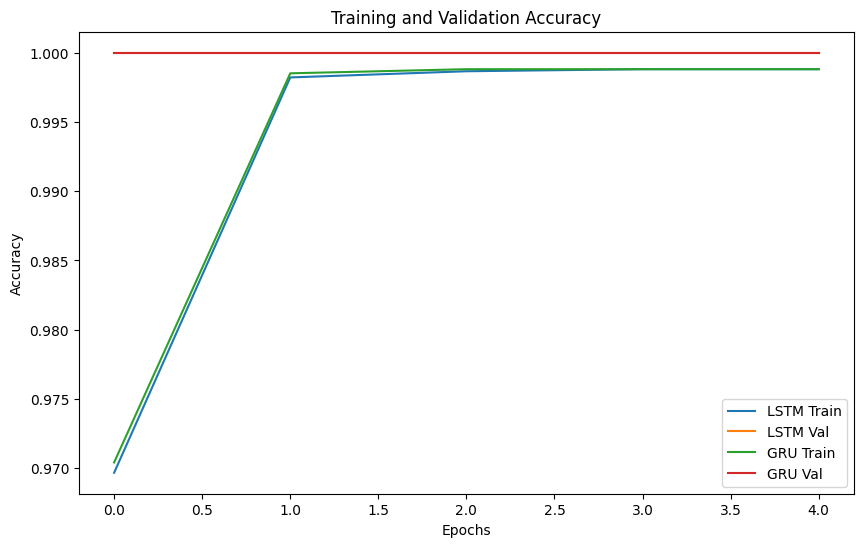

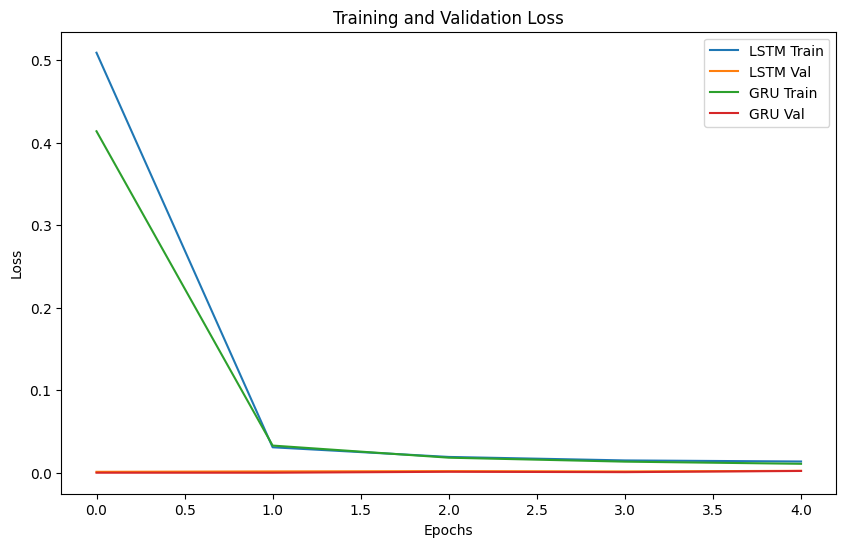

In [19]:
plot_history([lstm_history, gru_history], ['LSTM', 'GRU'], metric='accuracy')
plot_history([lstm_history, gru_history], ['LSTM', 'GRU'], metric='loss')

In [20]:
lstm_test_eval = lstm.evaluate([x_test, y_test_in], y_test_out, batch_size=64, verbose=1)
gru_test_eval = gru.evaluate([x_test, y_test_in], y_test_out, batch_size=64, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9999 - loss: 0.0041
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.9999 - loss: 0.0040


In [21]:
print(f'\nLSTM Test Loss: {lstm_test_eval[0]:.4f}, Test Accuracy: {lstm_test_eval[1]:.4f}')
print(f'GRU Test Loss:  {gru_test_eval[0]:.4f}, Test Accuracy: {gru_test_eval[1]:.4f}')


LSTM Test Loss: 0.0078, Test Accuracy: 0.9995
GRU Test Loss:  0.0082, Test Accuracy: 0.9995


In [22]:
metrics = ['Loss', 'Accuracy']
lstm_metrics = lstm_test_eval[:2]
gru_metrics = gru_test_eval[:2]

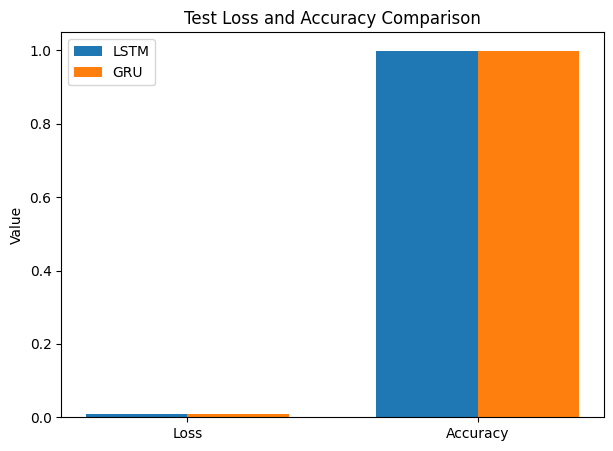

In [23]:
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 5))
rects1 = ax.bar(x - width/2, lstm_metrics, width, label='LSTM')
rects2 = ax.bar(x + width/2, gru_metrics, width, label='GRU')

ax.set_ylabel('Value')
ax.set_title('Test Loss and Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

In [24]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

In [25]:
autolabel(rects1)
autolabel(rects2)

plt.show()